In [135]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt



np.random.seed(1337) # for reproducibility

# from tensorflow import set_random_seed
# set_random_seed(1337)
import tensorflow # x
tensorflow.random.set_seed(1337) # x
#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization, concatenate
from keras.layers.core import SpatialDropout2D, Activation

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [13]:
# Set some parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 5
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
#seed = 42
#random.seed = seed
#np.random.seed = seed

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [145]:
def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv



In [146]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    dice_list = [s for s in history.history.keys() if 'dice' in s and 'val' not in s]
    val_dice_list = [s for s in history.history.keys() if 'dice' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Dice Coefficient
    plt.figure(2)
    for l in dice_list:
        plt.plot(epochs, history.history[l], 'b', label='Training Dice Coefficient (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_dice_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation Dice Coefficient (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    ## Accuracy
    plt.figure(3)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [151]:
def ZF_UNET_224(dropout_val=0.2, weights=None):
    if K.image_data_format() == 'channels_last':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")

    #if weights == 'generator' and axis == 3 and INPUT_CHANNELS == 3 and OUTPUT_MASK_CHANNELS == 1:
    ##    weights_path = get_file(
     #       'zf_unet_224_weights_tf_dim_ordering_tf_generator.h5',
     #       ZF_UNET_224_WEIGHT_PATH,
     #       cache_subdir='models',
     #       file_hash='203146f209baf34ac0d793e1691f1ab7')
     #   model.load_weights(weights_path)

    return model

In [18]:
#X_validation = np.load("X_validation_ALL_RT224cti.npy")
#Y_validation = np.load("Y_validation_ALL_RT224cti.npy")
#X_test = np.load("X_test224cti.npy")
#Y_test = np.load("Y_test224.npy")
#X_validation = X_validation.astype('uint8')
#Y_validation = Y_validation.astype('uint8')
#X_test = X_test.astype('uint8')
#Y_test = Y_test.astype('uint8')

In [19]:
#X_validation = X_validation/255.0
#Y_validation = Y_validation/255.0
#X_test = X_test/255.0
#Y_test = Y_test/255.0

# All data 

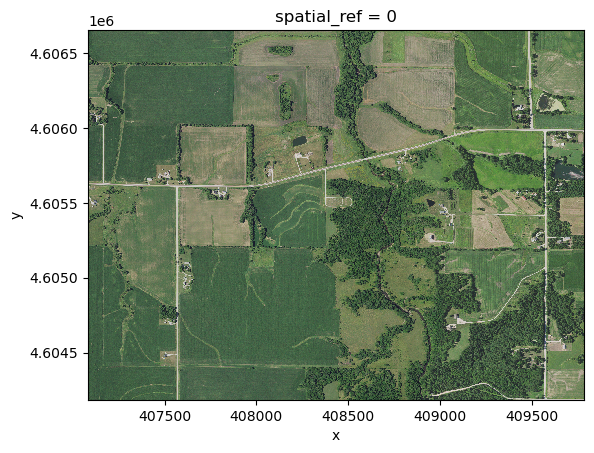

In [75]:
# 1. Concatenate NAIP and DEM along the channel dimension, now 5 channels (features)

import rioxarray
import xarray as xr

naip = rioxarray.open_rasterio("Data/Train/naip.tif")
dem = rioxarray.open_rasterio("Data/Train/dem.tif")
features = xr.concat((naip, dem), "band")

naip[:3, :, :].astype("uint8").plot.imshow()

In [119]:
# 2. Crop concatenated feature images into 224 by 224 chunks

import math
import numpy as np

w = features.rio.width
h = features.rio.height

chunks_per_row = math.ceil(w / 224)
num_chunks = chunks_per_row * math.ceil(h / 224)

feature_chunks = np.zeros((num_chunks, 5, 224, 224))

for i in range(0, h, 224):
    for j in range(0, w, 224):
        im = min(i + 224, h)
        jm = min(j + 224, w)
        
        chunk_id = (i*chunks_per_row + j) // 224
        feature_chunks[chunk_id, :, :im - i, :jm - j] = features[:, i:im, j:jm].expand_dims("chunk_id")

<AxesSubplot: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

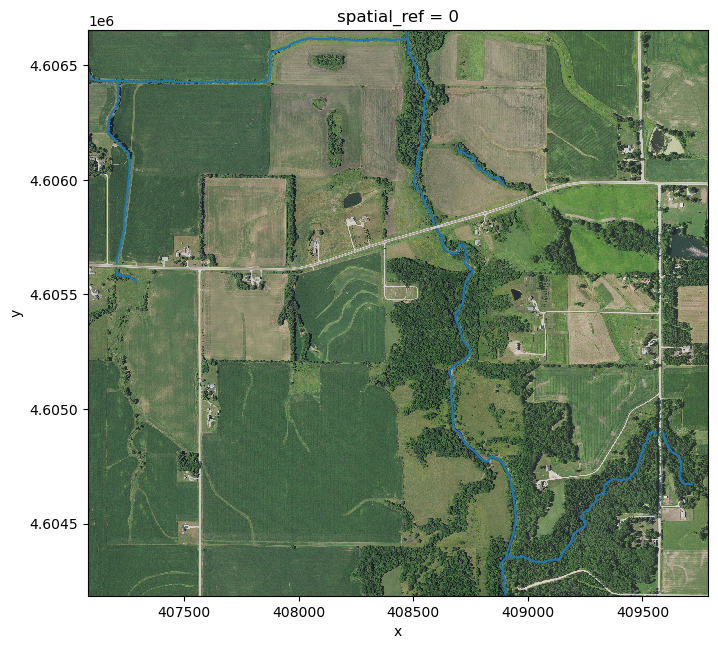

In [109]:
# 3. Rasterize the refinedlines.shp into the NAIP/DEM spatial grid framework

import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import features as rio_features

refined_lines_raw = gpd.read_file("Data/Train/refinedlines.shp")
refined_lines_vec = refined_lines_raw.to_crs(naip.rio.crs)
geom = refined_lines_vec.geometry
refined_lines = rio_features.rasterize(geom, out_shape=naip.shape[1:], fill=0, transform=naip.rio.transform())
refined_lines = xr.DataArray(refined_lines_raster)

fig, ax = plt.subplots(figsize=(8, 8))

naip[:3, :, :].astype("uint8").plot.imshow(ax=ax)
refined_lines_vec.plot(ax=ax)

In [ ]:
# 4. Crop rasterized refinedline (class) layer into 224 by 224 chunks, similar to above

w = features.rio.width
h = features.rio.height

chunks_per_row = math.ceil(w / 224)
num_chunks = chunks_per_row * math.ceil(h / 224)

refined_line_chunks = np.zeros((num_chunks, 1, 224, 224))

for i in range(0, h, 224):
    for j in range(0, w, 224):
        im = min(i + 224, h)
        jm = min(j + 224, w)
        
        chunk_id = (i*chunks_per_row + j) // 224
        refined_line_chunks[chunk_id, 0, :im - i, :jm - j] = refined_lines[i:im, j:jm].expand_dims("chunk_id")

np.save("X_train224.npy", feature_chunks)
np.save("Y_train224.npy", refined_line_chunks)

In [ ]:
# 5. Train a U-Net Model based on the X and Y

In [ ]:
X_train = np.load("X_train224.npy")
Y_train = np.load("Y_train224.npy")
X_train = X_train.astype('uint8')
Y_train = Y_train.astype('uint8')

In [152]:
model = ZF_UNET_224()
learning_rate =0.0001
patience = 20
model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss,metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('unetLr03.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]
# Fit model
results_03 = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=50,
                    callbacks=callbacks)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 2, 14, 1024), (None, 1, 14, 512)]

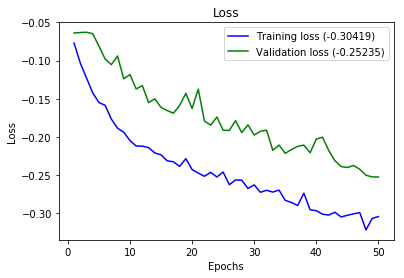

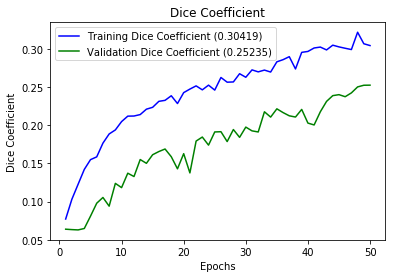

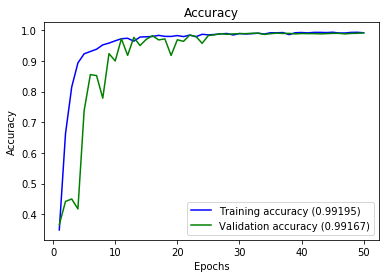

In [15]:
plot_history(results_03)

In [16]:
np.save("SL_results_03.npy",results_03.history)

In [27]:
X_test = np.load("X_test224cti.npy")
Y_test = np.load("Y_test224.npy")
X_test = X_test.astype('uint8')
Y_test = Y_test.astype('uint8')

In [28]:
X_test.shape

(12, 224, 224, 4)

In [29]:
Y_test.shape

(12, 224, 224, 1)

In [17]:
preds_test = model.predict(X_train)

In [18]:
preds_test.shape

(166, 224, 224, 1)

In [19]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [28]:
mappedResult = []
for i in range(0,X_train.shape[0]):
    curGT = Y_train[i]
    curPD = preds_test_t[i]
    values = curGT.copy()
    for x in range(0,IMG_WIDTH):
        for y in range(0,IMG_WIDTH):
            if curGT[x,y]==0 and curPD[x,y]==0:
                #print("here")
                values[x,y] = 0
            elif curGT[x,y]==0 and curPD[x,y]==1:
                #print("here1")
                values[x,y] = 1
            elif curGT[x,y]==1 and curPD[x,y]==0:
                #print("here2")
                values[x,y] = 2
            elif curGT[x,y]==1 and curPD[x,y]==1:
                values[x,y] = 3
    mappedResult.append(values)
    
mappedResult = np.asarray(mappedResult)

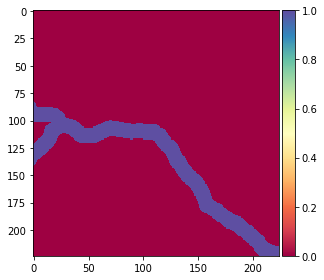

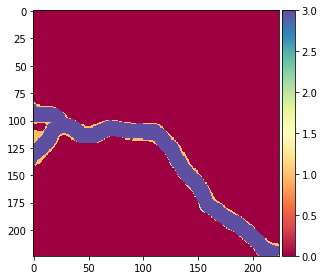

In [30]:
ix = 2
#imshow(np.squeeze(X_train[ix]))
#plt.show()
imshow(np.squeeze(Y_train[ix]),cmap=plt.cm.Spectral)
plt.show()
#imshow(np.squeeze(preds_test_t[ix]),cmap=plt.cm.Spectral)
#plt.show()
imshow(np.squeeze(mappedResult[ix]),cmap=plt.cm.Spectral)
plt.show()

In [37]:
preds_test_mod = preds_test_t
preds_test_mod.shape = preds_test_mod.shape[0] * 224*224 ,1
preds_test_mod2  = preds_test_mod.tolist()
predictionlist = [item for sublist in preds_test_mod2 for item in sublist]

In [38]:
groundtruth = Y_test
groundtruth.shape = groundtruth.shape[0] * 224*224 ,1
groundtruth  = groundtruth.tolist()
groundtruthlist = [item for sublist in groundtruth for item in sublist]

In [39]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
cm = confusion_matrix(groundtruthlist, predictionlist)

In [41]:
cm


array([[422580,  23577],
       [ 17630, 138325]], dtype=int64)

Confusion matrix, without normalization
[[422580  23577]
 [ 17630 138325]]


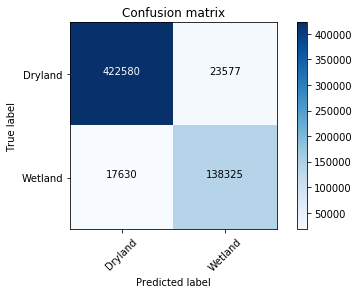

In [42]:
plot_confusion_matrix(cm,classes=["Dryland","Wetland"])

In [105]:
from sklearn.metrics import f1_score, precision_score,recall_score
print(f1_score(groundtruthlist, predictionlist, average='macro'))
print(precision_score(groundtruthlist, predictionlist,pos_label=1))
print(precision_score(groundtruthlist, predictionlist,pos_label=0))
print(recall_score(groundtruthlist, predictionlist,pos_label=1))
print(recall_score(groundtruthlist, predictionlist,pos_label=0))

0.8778533403431648
0.85982655880452
0.9243597108266586
0.7762559712737649
0.9557644506306077


In [44]:
#new confusion Matrix with cti
from sklearn.metrics import f1_score, precision_score,recall_score
print(f1_score(groundtruthlist, predictionlist, average='macro'))
print(f1_score(groundtruthlist, predictionlist,pos_label=1))
print(f1_score(groundtruthlist, predictionlist,pos_label=0))
print(precision_score(groundtruthlist, predictionlist,pos_label=1))
print(precision_score(groundtruthlist, predictionlist,pos_label=0))
print(recall_score(groundtruthlist, predictionlist,pos_label=1))
print(recall_score(groundtruthlist, predictionlist,pos_label=0))

0.9119350847197911
0.8703599417348054
0.9535102277047769
0.854374868747761
0.9599509325094842
0.8869545702285916
0.9471553735568421


In [106]:
from sklearn.metrics import accuracy_score
print(accuracy_score(groundtruthlist, predictionlist))


0.9092693718112245


In [107]:
sum(groundtruthlist)

155955

In [109]:
len(groundtruthlist)

602112

In [110]:
len(groundtruthlist)-sum(groundtruthlist)

446157

In [111]:
print(f1_score(groundtruthlist, predictionlist, pos_label=1))

0.8159068852105461


In [112]:
print(f1_score(groundtruthlist, predictionlist, pos_label=0))

0.9397997954757834


In [ ]:
a = f1_score(groundtruthlist, predictionlist, pos_label=1)
b= f1_score(groundtruthlist, predictionlist, pos_label=0)
c =(a+b)/2
c

In [10]:
model = load_model('unetLr03.h5', custom_objects={'dice_coef': dice_coef,'dice_coef_loss':dice_coef_loss})

TypeError: ('Keyword argument not understood:', 'interpolation')

In [ ]:
preds_test = model.predict(X_train)

In [11]:
preds_test.shape

NameError: name 'preds_test' is not defined

In [ ]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
mappedResult = []
for i in range(0,X_train.shape[0]):
    curGT = Y_train[i]
    curPD = preds_test_t[i]
    values = curGT.copy()
    for x in range(0,IMG_WIDTH):
        for y in range(0,IMG_WIDTH):
            if curGT[x,y]==0 and curPD[x,y]==0:
                #print("here")
                values[x,y] = 0
            elif curGT[x,y]==0 and curPD[x,y]==1:
                #print("here1")
                values[x,y] = 1
            elif curGT[x,y]==1 and curPD[x,y]==0:
                #print("here2")
                values[x,y] = 2
            elif curGT[x,y]==1 and curPD[x,y]==1:
                values[x,y] = 3
    mappedResult.append(values)
    
mappedResult = np.asarray(mappedResult)

# TestMap

In [4]:
Y_test = np.load("Y_testMap.npy")


FileNotFoundError: [Errno 2] No such file or directory: 'TestmappedResult'

In [5]:
mappedResult = np.load("TestmappedResult.npy")

In [14]:
Y_test = Y_test.astype('uint8')
mappedResult =mappedResult.astype('uint8')

757


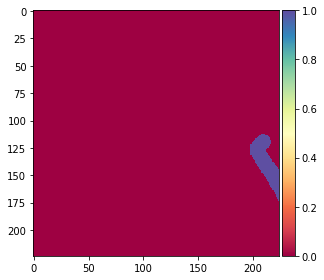

758


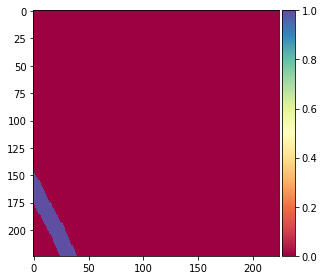

820


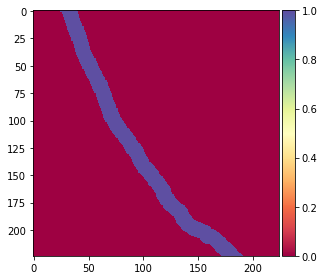

882


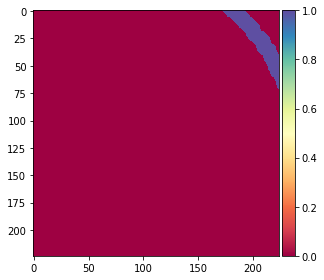

883


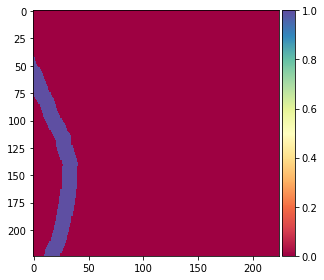

944


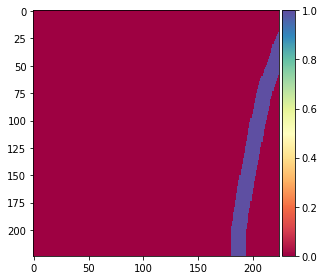

945


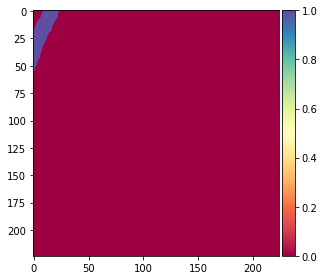

In [19]:
for ix in range(0,1000):
#ix = 75
#imshow(np.squeeze(X_train[ix]))
#plt.show()
    if(Y_test[ix].sum()>500):
        print(ix)
        imshow(np.squeeze(Y_test[ix]),cmap=plt.cm.Spectral)
        plt.show()
#imshow(np.squeeze(preds_test_t[ix]),cmap=plt.cm.Spectral)
#plt.show()
    #imshow(np.squeeze(mappedResult[ix]),cmap=plt.cm.Spectral)
    #plt.show()

In [11]:
mappedResult.sum()

2866413.0

In [25]:
X_testRGB = np.load("X_testRGB.npy")

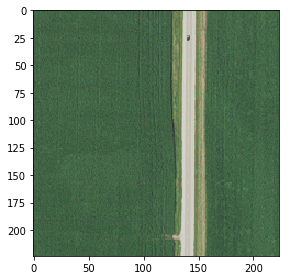

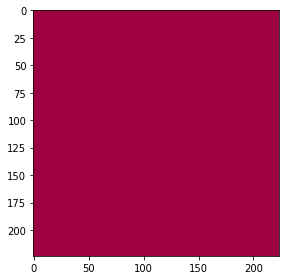

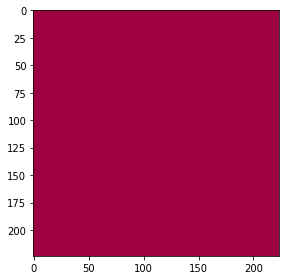

In [46]:
import random
ix=random.randint(300,900)
imshow(X_testRGB[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]),cmap=plt.cm.Spectral)
plt.show()
imshow(np.squeeze(mappedResult[ix]),cmap=plt.cm.Spectral)
plt.show()